Intention of the project : Classification of customer reviews based on the topics being spoken about. 

Assumption : each sentence of the review talks about only one topic 

Customer reviews on sports utility vehicle are split into sentences and manually tagged into various topics/clusters to check the accuracy of the excercise

# Importing Libraries

In [1]:
import pandas as pd 
from bs4 import BeautifulSoup
import contractions
import spacy
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from gsdmm_master.gsdmm.mgp import MovieGroupProcess

unable to import 'smart_open.gcs', disabling that module


# Inputing and Inspection of Data

In [2]:
data = pd.read_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/customerreviews_tagged.csv')

In [3]:
data.head()

,Opinions,Drivers
0,Saw the car on the road today and i found it t...,Road Presence
1,Built quality is very solid and a quick peppy ...,Build Quality
2,Even it's base model has all features and safe...,Safety Features
3,The diesel engine is providing extreme perform...,Performance
4,It's very comfortable and doesn't make us tire...,Comfort


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 2 columns):
Opinions    781 non-null object
Drivers     781 non-null object
dtypes: object(2)
memory usage: 12.3+ KB


In [5]:
data.Drivers.unique()

array(['Road Presence', 'Build Quality', 'Safety Features', 'Performance',
       'Comfort', 'Looks', 'Cost', 'Infotainment System',
       'Ground Clearance', 'Ventilated Seats', 'Sunroof', 'Boot Space',
       'Family Car', 'Wireless Charging', 'Mood Lights'], dtype=object)

We can see that there are 781 unique sentences that are manually tagged to 15 unique clusters under the column name "Drivers".

# Pre-Processing of Reviews

Some of the Standard Preprocessing for NLP on text are : 
1.removing HTML Tag 2.expanding contraction 3.Removing Stopwords 5.Removing punctuations 6.Removing special characters 7.Removing numbers 8.Lemmantization

In [6]:
# Removing HTML tags : as the review is web scrapped chances are that it may have HTML tags

# Creating a function to strip HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [7]:
# Applying the function to strip HTML Tags on our dataset 

data['Clean']=data['Opinions'].apply(strip_html_tags)

In [8]:
# Expanding Contractions

data['Clean']=data['Clean'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [9]:
# The data in the column "Clean" is in the form of a list, it needs to be converted back into a sentence 

data['Clean']=[' '.join(map(str, l)) for l in data['Clean']]

In [10]:
# loading the nlp object with a model 

nlp = spacy.load('en_core_web_md')

In [11]:
# Defining function for other preprocessing steps of removing stop words, punctuations, special characters, numbers and doing lemmantization

def other_preprocess(text):
    clean_text=[]
    doc = nlp(text)
    
    for token in doc:
        flag = True
        edit = token.text
        
        if token.is_stop:
            flag = False
        
        if token.pos_ == 'PUNCT' and flag == True:
            flag = False
            
        if token.pos_ == 'SYM' and flag == True:
            flag = False
            
        if flag == True and (token.pos_ == 'NUM' or token.text.isnumeric()):
            flag = False
        
        elif token.lemma_ != "-PRON-" and flag == True: 
            edit = token.lemma_
            
        if edit !="" and flag == True:
            clean_text.append(edit)
            
    return clean_text

In [12]:
# Applying the 'other_preprocess' function on the data set

data['Clean']=data['Clean'].apply(other_preprocess)

In [13]:
# Checking the dataset for the preprocessing steps

data.head()

,Opinions,Drivers,Clean
0,Saw the car on the road today and i found it t...,Road Presence,"[see, car, road, today, find, good, road, pres..."
1,Built quality is very solid and a quick peppy ...,Build Quality,"[build, quality, solid, quick, peppy, engine]"
2,Even it's base model has all features and safe...,Safety Features,"[base, model, feature, safety, like, traction,..."
3,The diesel engine is providing extreme perform...,Performance,"[diesel, engine, provide, extreme, performance..."
4,It's very comfortable and doesn't make us tire...,Comfort,"[comfortable, tired]"


# Topic Modelling (1st Iteration) 

First we will apply the LDA Model to a range of clusters(number of Topics) and see which number of topics gives the maximum coherence score

In [14]:
# Creating a function to run LDA topic modelling for a range of clusters(number of topics) and to give the corresponding coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Creating dictionary

dictionary = corpora.Dictionary(data['Clean'])

In [16]:
# Creating Term Document Frequency

corpus = [dictionary.doc2bow(text) for text in data['Clean']]

In [17]:
## Applying TF-IDF to our corpus 

# initialize TF-IDF model
tfidf = models.TfidfModel(corpus)

# apply transformation to the entire corpus
transformed_corpus = tfidf[corpus]

In [18]:
# Creating a list of words(texts) for coherence score calculation 

text_list = data['Clean'].values.tolist()

text = [item for sublist in text_list for item in sublist]

Applying LDA clustering for a range of number of topics from 2 to 100 in steps of 5

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=transformed_corpus, texts=[text],start=2, limit=100, step=5)

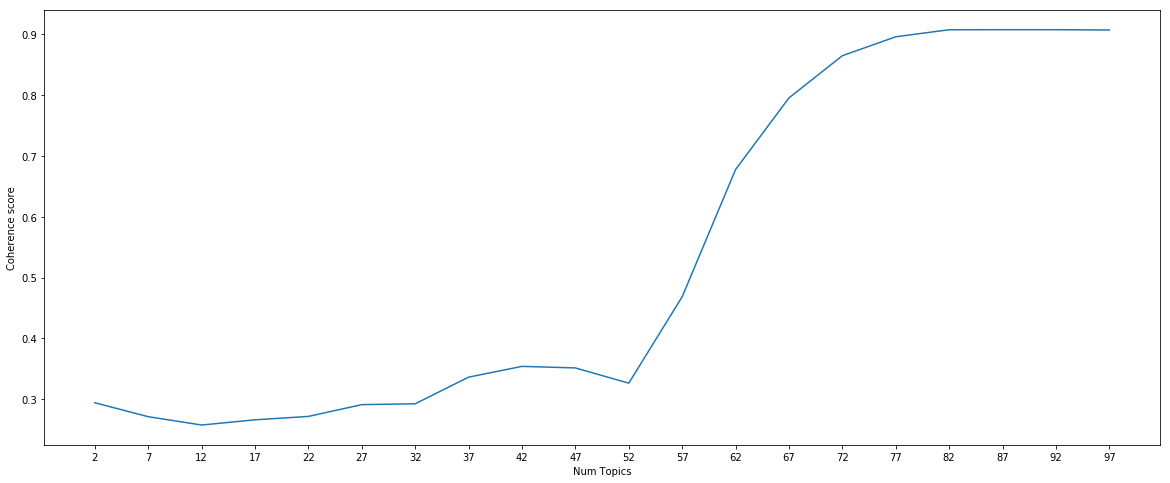

In [20]:
x = range(2,100,5)
plt.figure(figsize=(20,8))
plt.xticks(np.arange(2, 100, step=5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

From the above plot we can see that the coherence score decreases from 2, meeting the lowest point 17, Then increasing steadily till 42 (reaching a peak) and then decreasing till 52 

From 52 onwards we can see a large spike in the coherence score, and finally the curve flattens out at 77.

So some of the interesting points for consideration of number of topics are : 42, 77

# Topic Modelling (2nd Iteration)

Creating a LDA Topic Model for the points we discovered earlier and inspecting the model by visualising it

In [21]:
# function for creating a LDA model with number of topics as parameter

def lda_models(num_topic,dictionary,transformed_corpus,texts):
    lda_model = models.LdaMulticore(transformed_corpus, num_topics=num_topic, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=[texts], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    return lda_model

In [22]:
# function for visualisation of the LDA model

def visualisation(model):
    pyLDAvis.enable_notebook()

    vis = pyLDAvis.gensim.prepare(model,corpus,dictionary,mds='mmds')
    return vis

LDA Model with number of topics = 42

In [23]:
lda_42 = lda_models(num_topic=42,dictionary=dictionary, transformed_corpus=transformed_corpus, texts=text)


Coherence Score:  0.36570430299353535


In [24]:
visualisation(lda_42)

C:\Users\anton\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
31     0.099159  0.152323       1        1  11.063495
2      0.160951 -0.091328       2        1   3.895118
27     0.190443  0.046683       3        1   3.878309
8      0.105650 -0.014682       4        1   3.737235
24    -0.107163 -0.121749       5        1   3.616967
32    -0.135976  0.098017       6        1   3.595054
11     0.036940  0.196655       7        1   3.570069
16    -0.193630  0.068095       8        1   3.185781
41    -0.177741  0.006418       9        1   3.042153
15     0.062213  0.097311      10        1   2.918985
29    -0.013611  0.135121      11        1   2.759634
4     -0.085936  0.181192      12        1   2.585700
1      0.123672  0.027368      13        1   2.539496
6      0.031841  0.146054      14        1   2.422888
36    -0.083785  0.111364      15        1   2.314405
39     0.048805 -0.179336      16        1   2.282569
38    -0.069691 -0.148581      17        1   2.197872
21     0.147891 -0.013359      18        1   2.191709
26    -0.047499  0.120463      19        1   2.120157
22    -0.025744 -0.180910      20        1   2.088923
35     0.131528 -0.055842      21        1   2.084744
34     0.015986 -0.144992      22        1   2.058414
19    -0.101512  0.051284      23        1   1.997426
37     0.147546  0.103268      24        1   1.969064
25     0.096245  0.071086      25        1   1.901732
0     -0.040197 -0.109708      26        1   1.884849
23     0.028160 -0.062459      27        1   1.709796
3     -0.085563 -0.077524      28        1   1.683943
13     0.028358 -0.095893      29        1   1.665335
40     0.096263 -0.138894      30        1   1.651581
14    -0.150451 -0.080905      31        1   1.618877
5      0.096694 -0.099965      32        1   1.606814
33    -0.016590  0.058340      33        1   1.492850
30     0.048151 -0.015342      34        1   1.431960
12    -0.116024 -0.040989      35        1   1.431335
18    -0.126462 -0.000294      36        1   1.371883
20    -0.035000 -0.039542      37        1   1.335771
28     0.044298  0.028574      38        1   1.315050
7     -0.080012 -0.015117      39        1   1.068245
10    -0.043676  0.014254      40        1   0.973352
9     -0.008414 -0.010353      41        1   0.878989
17     0.003884  0.023893      42        1   0.861470, topic_info=     Category       Freq          Term      Total  loglift  logprob
242   Default  24.000000         great  24.000000  30.0000  30.0000
379   Default  25.000000     excellent  25.000000  29.0000  29.0000
69    Default  23.000000         space  23.000000  28.0000  28.0000
388   Default  25.000000       amazing  25.000000  27.0000  27.0000
62    Default  27.000000      interior  27.000000  26.0000  26.0000
64    Default  18.000000     panoramic  18.000000  25.0000  25.0000
66    Default  15.000000          boot  15.000000  24.0000  24.0000
336   Default  19.000000          high  19.000000  23.0000  23.0000
56    Default  32.000000       sunroof  32.000000  22.0000  22.0000
45    Default  12.000000        little  12.000000  21.0000  21.0000
43    Default  20.000000     clearance  20.000000  20.0000  20.0000
44    Default  20.000000        ground  20.000000  19.0000  19.0000
284   Default  18.000000          nice  18.000000  18.0000  18.0000
385   Default  18.000000       awesome  18.000000  17.0000  17.0000
3     Default  24.000000      presence  24.000000  16.0000  16.0000
10    Default  34.000000       quality  34.000000  15.0000  15.0000
19    Default  22.000000          like  22.000000  14.0000  14.0000
111   Default  22.000000         price  22.000000  13.0000  13.0000
213   Default  14.000000          come  14.000000  12.0000  12.0000
280   Default  24.000000         drive  24.000000  11.0000  11.0000
61    Default  17.000000          feel  17.000000  10.0000  10.0000
272   Default  12.000000           big  12.000000   9.0000   9.0000
387   Default  11

We can see that there are many adjetives like good, great, excellent, amazing influencing the clustering. 

As we are not using bigrams or trigrams. These words don't add much value to the report and thereby they need to be removed for the LDA models. 

# Topic Modelling (3rd Iteration)

Filtering out the adjectives from the sentences to remove the influence of adjectives in topic modelling

Checking the impact of removal of adjectives on the coherence score over a range of number of topics

In [25]:
# Compiling the list into strings to run the nlp model again and to filter the adjectives and 
# storing the string result in column Clean1

data['Clean1']=[' '.join(map(str, l)) for l in data['Clean']]

In [26]:
# Checking the data

data.head()

,Opinions,Drivers,Clean,Clean1
0,Saw the car on the road today and i found it t...,Road Presence,"[see, car, road, today, find, good, road, pres...",see car road today find good road presence
1,Built quality is very solid and a quick peppy ...,Build Quality,"[build, quality, solid, quick, peppy, engine]",build quality solid quick peppy engine
2,Even it's base model has all features and safe...,Safety Features,"[base, model, feature, safety, like, traction,...",base model feature safety like traction contro...
3,The diesel engine is providing extreme perform...,Performance,"[diesel, engine, provide, extreme, performance...",diesel engine provide extreme performance car ...
4,It's very comfortable and doesn't make us tire...,Comfort,"[comfortable, tired]",comfortable tired


In [27]:
# Creating a function to filter 'ADJ' parts of speech 

def adj_filter(text):
    non_adj = []
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ != 'ADJ':
            non_adj.append(token.lemma_)
            
    return non_adj

In [28]:
# Applying to the entire 'Clean1' column

data['Clean1']=data['Clean1'].apply(adj_filter)

In [29]:
# Checking the data

data.head()

,Opinions,Drivers,Clean,Clean1
0,Saw the car on the road today and i found it t...,Road Presence,"[see, car, road, today, find, good, road, pres...","[see, car, road, today, find, road, presence]"
1,Built quality is very solid and a quick peppy ...,Build Quality,"[build, quality, solid, quick, peppy, engine]","[build, quality, engine]"
2,Even it's base model has all features and safe...,Safety Features,"[base, model, feature, safety, like, traction,...","[base, model, feature, safety, like, traction,..."
3,The diesel engine is providing extreme perform...,Performance,"[diesel, engine, provide, extreme, performance...","[diesel, engine, provide, performance, car, li..."
4,It's very comfortable and doesn't make us tire...,Comfort,"[comfortable, tired]",[]


As we can see that some of the some of the elements in Clean1 are empty.

We need to remove that to build the dictionary

In [30]:
# Removing empty Clean1 list and moving it to a new dataframe

data_new = data[data['Clean1'].map(lambda d: len(d)) > 0]

In [31]:
# Checking if the empty list rows are removed

data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 780
Data columns (total 4 columns):
Opinions    776 non-null object
Drivers     776 non-null object
Clean       776 non-null object
Clean1      776 non-null object
dtypes: object(4)
memory usage: 30.3+ KB


In [32]:
# Resetting the index of the dataframe

data_new.reset_index(drop=True, inplace=True)

In [33]:
# Building the new dictionary

dictionary_new = corpora.Dictionary(data_new['Clean1'])

In [34]:
# Creating New Term Document Frequency

corpus_new = [dictionary_new.doc2bow(text) for text in data['Clean1']]

In [35]:
## Applying TF-IDF to our new corpus 

# initialize TF-IDF model
tfidf = models.TfidfModel(corpus_new)

# apply transformation to the entire corpus
transformed_corpus_new = tfidf[corpus_new]

In [36]:
# Creating a new list of text for coherence score calculation 

text_list_new = data['Clean1'].values.tolist()

text_new = [item for sublist in text_list_new for item in sublist]

Applying LDA Clustering on the new dataset and visualising it to see if there is improvement in coherence score

In [37]:
model_list_new, coherence_values_new = compute_coherence_values(dictionary=dictionary_new, corpus=transformed_corpus_new, texts=[text_new],start=2, limit=100, step=5)

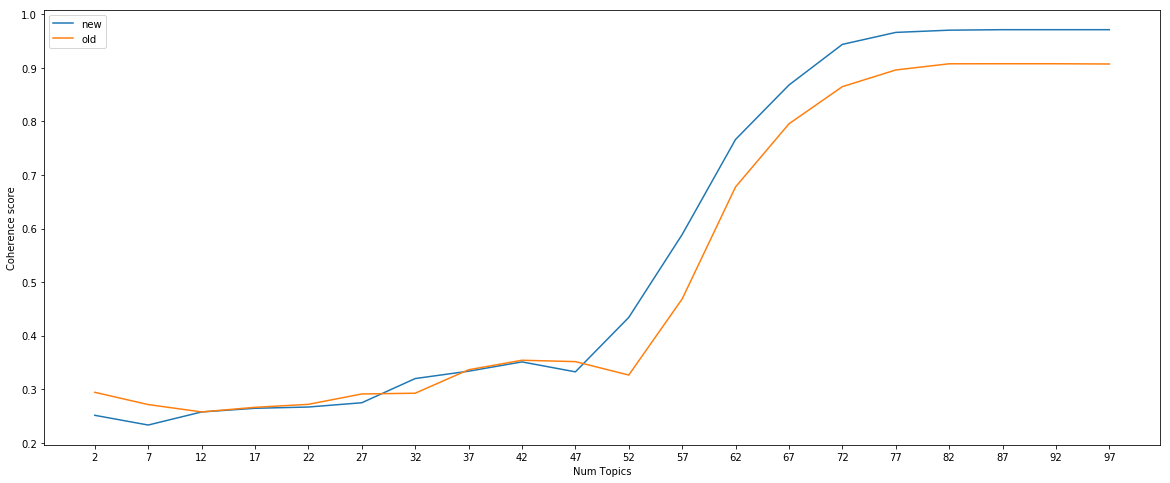

In [38]:
x = range(2,100,5)
plt.figure(figsize=(20,8))
plt.xticks(np.arange(2, 100, step=5))
plt.plot(x, coherence_values_new, label='new')
plt.plot(x, coherence_values, label='old')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

There is a slight increase in coherence value for certain points before 52, but after point 52, the coherence value for the model without adjectives is higher than the one with adjectives. 

Some of the key points for the new approach is 42 and 77. 

# LDA Topic Modelling 

We will be assigning the reviews to clusters for 4 models ( at number of topics : 42, 77 with adjectives & at number of topics : 42, 77 without adjectives ) 

Will analyse the results later 

In [39]:
# Function to assign dominant topic for each review

def dominant_topic(model,data,corpus,column_name):
    
    topic=[]
    for i in range(len(data)):
        topic.append(model[corpus[i]])
        
    data['Topic']=pd.Series(topic)
    
    dominant_topic=[]
    for l in data['Topic']:
        gg = max(l,key=lambda item:item[1])
        dominant_topic.append(gg)   
    data[column_name]=pd.Series(dominant_topic)
    data.drop(['Topic'],axis =1,inplace=True)

In [40]:
# Training model with number of topics 42, on data with adjectives 

wAd_lda_42 = lda_models(num_topic=42,dictionary=dictionary, transformed_corpus=transformed_corpus, texts=text)


Coherence Score:  0.3488718892618102


In [41]:
dominant_topic(model=wAd_lda_42,data=data,corpus=corpus,column_name='wAd_lda_42')

In [42]:
# Training model with number of topics 77, on data with adjectives

wAd_lda_77 = lda_models(num_topic=77,dictionary=dictionary, transformed_corpus=transformed_corpus, texts=text)


Coherence Score:  0.9067790870730643


In [43]:
dominant_topic(model=wAd_lda_77,data=data,corpus=corpus,column_name='wAd_lda_77')

In [44]:
# Training model with number of topics 42, on data without adjectives

nAd_lda_42 = lda_models(num_topic=42,dictionary=dictionary_new, transformed_corpus=transformed_corpus_new, texts=text_new)


Coherence Score:  0.3481859610621902


In [45]:
dominant_topic(model=nAd_lda_42,data=data_new,corpus=corpus_new,column_name='nAd_lda_42')

C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [46]:
# Training model with number of topics 77, on data without adjectives

nAd_lda_77 = lda_models(num_topic=77,dictionary=dictionary_new, transformed_corpus=transformed_corpus_new, texts=text_new)


Coherence Score:  0.9615907174270533


In [47]:
dominant_topic(model=nAd_lda_77,data=data_new,corpus=corpus_new,column_name='nAd_lda_77')

C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


We got two dataframes : one for with adjectives and one for without adjectives. 


We need to combine the two dataframes and remove the unwanted columns and union the dataframe on the column 'Opinions' to make it easier for analysis

In [48]:
# Removing columns which are not required for our analysis

data_wAd=data.drop(['Clean','Clean1'],axis =1)
data_nAd=data_new.drop(['Clean','Clean1'],axis=1)

In [49]:
# Merging/ Joining the two dataframe into one to form the intrim dataset : the intrim dataset will be joined with the STTM output and will get the final dataset

data_intrim = pd.merge(data_wAd,data_nAd,on=['Opinions','Drivers'],how='outer')

In [50]:
# inspecting if the data_intrim is in proper format

print(data_intrim.head())
print(data_intrim.info())

                                            Opinions          Drivers  \
0  Saw the car on the road today and i found it t...    Road Presence   
1  Built quality is very solid and a quick peppy ...    Build Quality   
2  Even it's base model has all features and safe...  Safety Features   
3  The diesel engine is providing extreme perform...      Performance   
4  It's very comfortable and doesn't make us tire...          Comfort   

        wAd_lda_42        wAd_lda_77        nAd_lda_42        nAd_lda_77  
0   (5, 0.8915308)   (64, 0.5026098)  (38, 0.87796617)   (47, 0.5024865)  
1  (4, 0.48475575)  (0, 0.012987013)   (2, 0.49263254)   (47, 0.6700713)  
2  (14, 0.5741521)   (64, 0.4982919)   (19, 0.7791085)   (38, 0.5050754)  
3  (28, 0.7127592)  (0, 0.012987013)  (27, 0.49390998)  (35, 0.12695713)  
4  (18, 0.5118924)  (3, 0.012987017)               NaN               NaN  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, 0 to 780
Data columns (total 6 columns):
Opinion

# Short Text Topic Modelling

Another approach for topic modelling is STTM 

This model was build to overcome the shortcomings of LDA topic modelling on short texts

We will try STTM on num of topics : 42 and 77 (the number of topics we did for the earlier models)

In [51]:
# Model with number of topics as 42

mgp_42 = MovieGroupProcess(K=42, alpha=0.1, beta=0.1, n_iters=30)

In [52]:
# Model with number of topics as 77

mgp_77 = MovieGroupProcess(K=77, alpha=0.1, beta=0.1, n_iters=30)

In [53]:
# to find the length of the vocabulary 

vocab = set(x for doc in data_new['Clean1'] for x in doc)
n_terms = len(vocab)

In [54]:
# fitting the model with number of topics 42

y = mgp_42.fit(data_new['Clean1'], n_terms)

In stage 0: transferred 683 clusters with 42 clusters populated
In stage 1: transferred 494 clusters with 40 clusters populated
In stage 2: transferred 346 clusters with 35 clusters populated
In stage 3: transferred 322 clusters with 30 clusters populated
In stage 4: transferred 291 clusters with 28 clusters populated
In stage 5: transferred 273 clusters with 25 clusters populated
In stage 6: transferred 255 clusters with 25 clusters populated
In stage 7: transferred 260 clusters with 23 clusters populated
In stage 8: transferred 259 clusters with 23 clusters populated
In stage 9: transferred 233 clusters with 22 clusters populated
In stage 10: transferred 212 clusters with 20 clusters populated
In stage 11: transferred 186 clusters with 21 clusters populated
In stage 12: transferred 209 clusters with 22 clusters populated
In stage 13: transferred 221 clusters with 21 clusters populated
In stage 14: transferred 227 clusters with 22 clusters populated
In stage 15: transferred 215 cluste

In [55]:
# fitting the model with number of topics 77

x = mgp_77.fit(data_new['Clean1'], n_terms)

In stage 0: transferred 716 clusters with 68 clusters populated
In stage 1: transferred 503 clusters with 54 clusters populated
In stage 2: transferred 365 clusters with 41 clusters populated
In stage 3: transferred 337 clusters with 32 clusters populated
In stage 4: transferred 281 clusters with 29 clusters populated
In stage 5: transferred 255 clusters with 29 clusters populated
In stage 6: transferred 264 clusters with 24 clusters populated
In stage 7: transferred 227 clusters with 23 clusters populated
In stage 8: transferred 238 clusters with 23 clusters populated
In stage 9: transferred 208 clusters with 24 clusters populated
In stage 10: transferred 223 clusters with 25 clusters populated
In stage 11: transferred 220 clusters with 24 clusters populated
In stage 12: transferred 219 clusters with 23 clusters populated
In stage 13: transferred 218 clusters with 22 clusters populated
In stage 14: transferred 207 clusters with 21 clusters populated
In stage 15: transferred 207 cluste

In [56]:
# function to add sttm topics assigned by the model

def add_STTM_topics(model,column_name):
    sttm = []
    
    for i in data_new['Clean1']:
        stm = model.choose_best_label(i)
        sttm.append(stm)
        
    data_new[column_name] = pd.Series(sttm)

In [57]:
# assinging the reviews with sttm model with 77 no. of topics

add_STTM_topics(mgp_77,'sttm_77')

C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [58]:
# assinging the reviews with sttm model with 42 no. of topics

add_STTM_topics(mgp_42,'sttm_42')

C:\Users\anton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [59]:
# to make the dataset proper to be added to the data_intrim

data_sttm = data_new.drop(['Clean','Clean1','nAd_lda_42','nAd_lda_77'],axis=1)

In [60]:
# joining the above dataset with the intrim dataset to make the final dataset

data_final = pd.merge(data_intrim,data_sttm,on=['Opinions','Drivers'],how='outer')

In [61]:
# inspecting if the data_final is in proper format

print(data_final.head())
print(data_final.info())

                                            Opinions          Drivers  \
0  Saw the car on the road today and i found it t...    Road Presence   
1  Built quality is very solid and a quick peppy ...    Build Quality   
2  Even it's base model has all features and safe...  Safety Features   
3  The diesel engine is providing extreme perform...      Performance   
4  It's very comfortable and doesn't make us tire...          Comfort   

        wAd_lda_42        wAd_lda_77        nAd_lda_42        nAd_lda_77  \
0   (5, 0.8915308)   (64, 0.5026098)  (38, 0.87796617)   (47, 0.5024865)   
1  (4, 0.48475575)  (0, 0.012987013)   (2, 0.49263254)   (47, 0.6700713)   
2  (14, 0.5741521)   (64, 0.4982919)   (19, 0.7791085)   (38, 0.5050754)   
3  (28, 0.7127592)  (0, 0.012987013)  (27, 0.49390998)  (35, 0.12695713)   
4  (18, 0.5118924)  (3, 0.012987017)               NaN               NaN   

                    sttm_77                   sttm_42  
0  (51, 0.9994642540565671)   (22, 0.99999989900

# Preparing the Dataset for Analysis

In [63]:
# Dropping NA values to avoid getting errors 

data_final.dropna(inplace=True)

In [64]:
# Checking the dataframe if the NA values are removed

data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 780
Data columns (total 8 columns):
Opinions      776 non-null object
Drivers       776 non-null object
wAd_lda_42    776 non-null object
wAd_lda_77    776 non-null object
nAd_lda_42    776 non-null object
nAd_lda_77    776 non-null object
sttm_77       776 non-null object
sttm_42       776 non-null object
dtypes: object(8)
memory usage: 54.6+ KB


In [65]:
# Defining a function to seperate the percentage and cluster number from the tuple 

def cluster_per(dataframe,column_names,clusters,percentages):
    
    dataframe[clusters]=None
    dataframe[percentages]=None
    for ind in dataframe.index:
        dataframe[clusters][ind] = dataframe[column_names][ind][0]
        dataframe[percentages][ind] = dataframe[column_names][ind][1]

In [66]:
# Creating a list of column names to pass as parameter in the 'cluster_per' function

column_name = data_final.columns.tolist()

In [67]:
column_name

['Opinions',
 'Drivers',
 'wAd_lda_42',
 'wAd_lda_77',
 'nAd_lda_42',
 'nAd_lda_77',
 'sttm_77',
 'sttm_42']

In [68]:
# Slicing the column name to get only the required column names 

column_name = column_name[2:]

In [69]:
#checking if the list column_name has only the relevant names

column_name

['wAd_lda_42', 'wAd_lda_77', 'nAd_lda_42', 'nAd_lda_77', 'sttm_77', 'sttm_42']

In [70]:
# Applying the cluster_per function on the required column names

for i in column_name: 
    x='cluster_'+i
    y='percentage_'+i
    
    cluster_per(dataframe=data_final,column_names=i,clusters=x,percentages=y)

In [71]:
# Inspecting the data_final dataframe

data_final.head()

,Opinions,Drivers,wAd_lda_42,wAd_lda_77,nAd_lda_42,nAd_lda_77,sttm_77,sttm_42,cluster_wAd_lda_42,percentage_wAd_lda_42,cluster_wAd_lda_77,percentage_wAd_lda_77,cluster_nAd_lda_42,percentage_nAd_lda_42,cluster_nAd_lda_77,percentage_nAd_lda_77,cluster_sttm_77,percentage_sttm_77,cluster_sttm_42,percentage_sttm_42
0,Saw the car on the road today and i found it t...,Road Presence,"(5, 0.8915308)","(64, 0.5026098)","(38, 0.87796617)","(47, 0.5024865)","(51, 0.9994642540565671)","(22, 0.999999899008503)",5,0.891531,64,0.50261,38,0.877966,47,0.502487,51,0.999464,22,1
1,Built quality is very solid and a quick peppy ...,Build Quality,"(4, 0.48475575)","(0, 0.012987013)","(2, 0.49263254)","(47, 0.6700713)","(51, 0.999825267943253)","(21, 0.9594931409441672)",4,0.484756,0,0.012987,2,0.492633,47,0.670071,51,0.999825,21,0.959493
2,Even it's base model has all features and safe...,Safety Features,"(14, 0.5741521)","(64, 0.4982919)","(19, 0.7791085)","(38, 0.5050754)","(57, 0.9999999999990847)","(15, 0.9999999999856236)",14,0.574152,64,0.498292,19,0.779109,38,0.505075,57,1,15,1
3,The diesel engine is providing extreme perform...,Performance,"(28, 0.7127592)","(0, 0.012987013)","(27, 0.49390998)","(35, 0.12695713)","(34, 0.9999983137165108)","(17, 0.9991422624372174)",28,0.712759,0,0.012987,27,0.49391,35,0.126957,34,0.999998,17,0.999142
5,The black and white colors look very aesthetic.,Looks,"(15, 0.6687123)","(73, 0.50603825)","(0, 0.023809524)","(0, 0.012987013)","(27, 0.8869739918361532)","(5, 0.7923407506614227)",15,0.668712,73,0.506038,0,0.0238095,0,0.012987,27,0.886974,5,0.792341


In [72]:
# Dropping the column names which are not required 

data_final = data_final.drop(column_name, axis=1)

In [73]:
# Renaming the column name 

data_final = data_final.rename(columns={'Drivers':'Original Drivers'})

In [74]:
# Function to assign the opinions with the new drivers assigned by the model

## What is being done is we check for each cluster number assigned by the model, which manually tagged cluster is the most 
#The entire cluster number is then assigned the most occuring manually tagged cluster

def assigning_drivers(dataframe,model):
    c = "cluster_"+model
    p = "percentage_"+model
    ac = "Assigned_cluster_"+model
    subset = dataframe[['Opinions','Original Drivers',c,p]]
    
    group = subset.groupby([c,'Original Drivers']).count()
    group = group.reset_index()
    group = group.drop(p,axis = 1)
    idx = group.groupby([c])['Opinions'].transform(max) == group['Opinions']
    group_test = group[idx]
    
    group_test = group_test.drop_duplicates(subset = c,keep = False)
    group_test = group_test.rename(columns={'Original Drivers':ac,'Opinions':'Count for max cluster'})
    
    merge_inner = pd.merge(left = subset, right = group_test, left_on = c, right_on = c)
    
    return merge_inner

In [75]:
# Creating an empty list to store all the output files 

output_files = []

In [76]:
# Creating the output files for each model 

for i in column_name: 
    i = assigning_drivers(dataframe=data_final,model=i)
    output_files.append(i)

# Analysis of Topic Modelling

So far, we have done topic modelling using 6 seperate types of models.

Let us analyse the accuracy of each model and see which performs the best

In [77]:
# Function to highlight the maximum value in a dataframe/series

## this function will be used in the function below to see the cluster spread of the models

def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [78]:
# Function to check the accuracy and further analysis of the model

def accuracy(model,dataframe):
    c = "cluster_"+model
    p = "percentage_"+model
    ac = "Assigned_cluster_"+model
    
    dataframe = dataframe.rename(columns={c:'Assigned Cluster Number',p:'Percentage of Confidence in Assigned Cluster Number',ac:'Assigned Driver'})
    dataframe['Model'] = model
    
    print('Model Analysis ----------------------------------------------------------------------------------->>',model)
    print('----------------------------------------------------------------------------------------------------')
    
    original_drivers_count = dataframe['Original Drivers'].value_counts()
    print('Original Drivers Count ------------------------------------------------------------------')
    print(original_drivers_count)
    
    assigned_drivers_count = dataframe['Assigned Driver'].value_counts()
    print('Assigned Drivers Count ------------------------------------------------------------------')
    print(assigned_drivers_count)
    
    counter = 0
    total = 0
    for ind in dataframe.index:
        total = total+1
        if dataframe['Original Drivers'][ind] == dataframe['Assigned Driver'][ind]:
            counter = counter + 1
            
    Overall_Accuracy = counter/total*100
    
    print('The Model ',model,' has an overall accuracy of ',Overall_Accuracy,"%")
    
    cluster_spread = pd.crosstab(dataframe['Original Drivers'], dataframe['Assigned Driver'], normalize='index') * 100
    cluster_spread = cluster_spread.style.apply(highlight_max)
    
    print('Cluster Spread for the model',model,'  ----------------------------------->')
    display(cluster_spread)
    
    print('----------------------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------------')
    
    return dataframe

The six model names are stored in the 'column_name' list and the 'output_file' list is a list of dataframes containing the output for each model at the same index location as 'column_name'

In [79]:
column_name

['wAd_lda_42', 'wAd_lda_77', 'nAd_lda_42', 'nAd_lda_77', 'sttm_77', 'sttm_42']

In [80]:
# Creating an empty dataframe to upload the model output after analysis

output = pd.DataFrame()

In [81]:
# Analysing all the models and adding the results in the output dataframe created earlier

for i in range(len(column_name)):
    a = column_name[i]
    a= accuracy(model=column_name[i],dataframe=output_files[i])
    output = pd.concat([output,a])

Model Analysis ----------------------------------------------------------------------------------->> wAd_lda_42
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            104
Looks                   77
Comfort                 72
Cost                    71
Sunroof                 71
Safety Features         60
Infotainment System     49
Road Presence           41
Build Quality           40
Boot Space              31
Ground Clearance        27
Family Car              22
Ventilated Seats        21
Wireless Charging       18
Mood Lights              7
Name: Original Drivers, dtype: int64
Assigned Drivers Count ------------------------------------------------------------------
Performance            133
Cost                   130
Comfort                 90
Looks                   82
Sunroof                 74
Infotainment System     68
Saf

Assigned Driver,Build Quality,Comfort,Cost,Ground Clearance,Infotainment System,Looks,Performance,Road Presence,Safety Features,Sunroof,Ventilated Seats
Original Drivers,,,,,,,,,,,
Boot Space,0,3.22581,16.129,16.129,9.67742,3.22581,6.45161,41.9355,0,0,3.22581
Build Quality,15,7.5,17.5,0,27.5,2.5,20,0,0,7.5,2.5
Comfort,1.38889,51.3889,13.8889,1.38889,4.16667,9.72222,1.38889,0,5.55556,11.1111,0
Cost,0,7.04225,59.1549,0,8.4507,8.4507,1.40845,1.40845,2.8169,9.85915,1.40845
Family Car,0,40.9091,13.6364,0,4.54545,4.54545,31.8182,0,4.54545,0,0
Ground Clearance,0,3.7037,7.40741,40.7407,0,22.2222,11.1111,3.7037,3.7037,7.40741,0
Infotainment System,0,2.04082,8.16327,4.08163,34.6939,8.16327,12.2449,2.04082,6.12245,22.449,0
Looks,0,5.19481,12.987,0,12.987,33.7662,20.7792,2.5974,7.79221,3.8961,0
Mood Lights,14.2857,0,42.8571,28.5714,0,0,0,0,0,14.2857,0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model Analysis ----------------------------------------------------------------------------------->> wAd_lda_77
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            113
Looks                   81
Comfort                 81
Sunroof   

Assigned Driver,Comfort,Cost,Infotainment System,Performance,Safety Features,Sunroof
Original Drivers,,,,,,
Boot Space,6.06061,72.7273,3.0303,0,6.06061,12.1212
Build Quality,10.8696,17.3913,6.52174,41.3043,13.0435,10.8696
Comfort,29.6296,6.17284,8.64198,18.5185,3.7037,33.3333
Cost,19.4805,37.6623,10.3896,3.8961,6.49351,22.0779
Family Car,20,16,4,52,0,8
Ground Clearance,3.44828,27.5862,13.7931,41.3793,3.44828,10.3448
Infotainment System,5.55556,1.85185,72.2222,12.963,7.40741,0
Looks,7.40741,3.7037,12.3457,64.1975,6.17284,6.17284
Mood Lights,0,0,0,71.4286,0,28.5714


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model Analysis ----------------------------------------------------------------------------------->> nAd_lda_42
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            88
Looks                  62
Cost                   59
Comfort      

Assigned Driver,Comfort,Cost,Ground Clearance,Infotainment System,Looks,Performance,Road Presence,Safety Features,Sunroof
Original Drivers,,,,,,,,,
Boot Space,10.5263,5.26316,0,5.26316,5.26316,52.6316,0,5.26316,15.7895
Build Quality,6.45161,6.45161,3.22581,0,9.67742,41.9355,6.45161,22.5806,3.22581
Comfort,18.6441,6.77966,5.08475,1.69492,8.47458,40.678,5.08475,6.77966,6.77966
Cost,0,20.339,3.38983,0,8.47458,42.3729,5.08475,13.5593,6.77966
Family Car,8.33333,25,0,0,8.33333,33.3333,0,8.33333,16.6667
Ground Clearance,4.16667,16.6667,16.6667,0,8.33333,33.3333,4.16667,12.5,4.16667
Infotainment System,7.69231,5.12821,2.5641,5.12821,10.2564,58.9744,2.5641,2.5641,5.12821
Looks,8.06452,6.45161,4.83871,0,17.7419,51.6129,1.6129,9.67742,0
Mood Lights,0,20,0,20,0,60,0,0,0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model Analysis ----------------------------------------------------------------------------------->> nAd_lda_77
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            113
Looks                   81
Comfort                 81
Sunroof   

Assigned Driver,Performance,Sunroof
Original Drivers,,
Boot Space,93.9394,6.06061
Build Quality,73.913,26.087
Comfort,87.6543,12.3457
Cost,84.4156,15.5844
Family Car,84,16
Ground Clearance,79.3103,20.6897
Infotainment System,92.5926,7.40741
Looks,87.6543,12.3457
Mood Lights,85.7143,14.2857


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model Analysis ----------------------------------------------------------------------------------->> sttm_77
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            113
Looks                   81
Comfort                 81
Cost         

Assigned Driver,Boot Space,Build Quality,Comfort,Cost,Infotainment System,Looks,Performance,Road Presence,Safety Features,Sunroof,Ventilated Seats,Wireless Charging
Original Drivers,,,,,,,,,,,,
Boot Space,78.7879,0,18.1818,3.0303,0,0,0,0,0,0,0,0
Build Quality,0,93.4783,0,6.52174,0,0,0,0,0,0,0,0
Comfort,1.23457,2.46914,29.6296,8.64198,3.7037,0,37.037,6.17284,0,0,11.1111,0
Cost,2.5974,5.19481,2.5974,63.6364,0,2.5974,11.6883,2.5974,1.2987,1.2987,3.8961,2.5974
Family Car,0,12,0,0,0,0,84,0,0,4,0,0
Ground Clearance,75.8621,10.3448,0,0,0,0,0,13.7931,0,0,0,0
Infotainment System,1.85185,9.25926,0,7.40741,77.7778,0,1.85185,0,0,0,1.85185,0
Looks,3.7037,40.7407,0,12.3457,2.46914,6.17284,29.6296,3.7037,0,1.23457,0,0
Mood Lights,0,0,0,0,85.7143,0,0,0,0,0,14.2857,0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Model Analysis ----------------------------------------------------------------------------------->> sttm_42
----------------------------------------------------------------------------------------------------
Original Drivers Count ------------------------------------------------------------------
Performance            111
Looks                   81
Comfort                 80
Sunroof      

Assigned Driver,Boot Space,Build Quality,Comfort,Cost,Ground Clearance,Infotainment System,Looks,Performance,Road Presence,Safety Features,Sunroof,Wireless Charging
Original Drivers,,,,,,,,,,,,
Boot Space,21.2121,0,0,0,0,0,0,66.6667,0,0,12.1212,0
Build Quality,0,84.0909,0,0,0,0,0,0,13.6364,2.27273,0,0
Comfort,1.25,2.5,33.75,1.25,0,0,0,35,5,1.25,10,10
Cost,1.35135,13.5135,0,33.7838,0,0,0,24.3243,1.35135,1.35135,20.2703,4.05405
Family Car,0,0,0,0,0,0,0,68,0,0,32,0
Ground Clearance,0,0,0,0,65.5172,0,0,31.0345,3.44828,0,0,0
Infotainment System,0,7.40741,0,0,1.85185,72.2222,0,3.7037,0,1.85185,5.55556,7.40741
Looks,0,9.87654,0,0,7.40741,2.46914,1.23457,46.9136,14.8148,1.23457,14.8148,1.23457
Mood Lights,0,0,0,0,0,14.2857,0,0,0,0,0,85.7143


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Short Text Topic Modelling are giving much better results than normal LDA models. STTM models are giving an accuracy of around 50% 


However for visualisation and analysis purposes, we will consider the following models 
wAD_lda_42,nAD_lda_42,sttm_77,sttm_42

# Getting Output Files for Visualisation

Getting the files ready for visualisation to dive deep into how the model is performing 

In [82]:
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4371 entries, 0 to 766
Data columns (total 7 columns):
Opinions                                               4371 non-null object
Original Drivers                                       4371 non-null object
Assigned Cluster Number                                4371 non-null object
Percentage of Confidence in Assigned Cluster Number    4371 non-null object
Assigned Driver                                        4371 non-null object
Count for max cluster                                  4371 non-null int64
Model                                                  4371 non-null object
dtypes: int64(1), object(6)
memory usage: 273.2+ KB


In [83]:
# Cross checking the clusters in the model

output['Model'].unique()

array(['wAd_lda_42', 'wAd_lda_77', 'nAd_lda_42', 'nAd_lda_77', 'sttm_77',
       'sttm_42'], dtype=object)

In [84]:
# Removing/Filtering the models that are not giving any satisfactory results

output = output.loc[(output['Model']!='wAd_lda_77')&(output['Model']!='nAd_lda_77')]

In [85]:
# Cross checking if the output file has only the relevant model output

output['Model'].unique()

array(['wAd_lda_42', 'nAd_lda_42', 'sttm_77', 'sttm_42'], dtype=object)

In [86]:
# Exporting the dataframe as CSV for visualisation

output.to_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/output.csv',index=False)

We also need the topic word distribution for each of the four models being considered for analysis

In [93]:
# Function to get word distribution from LDA models

def lda_word_dist(model):
    top_words_per_topic = []
    for t in range(model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in model.show_topic(t, topn = 10)])

    dataframe = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
    
    return dataframe

In [94]:
# Applying the word distribution function for lda model wAd_lda_42

df_wAd_lda_42 = lda_word_dist(model=wAd_lda_42)

In [96]:
# Exporting the dataframe as CSV for visualisation

df_wAd_lda_42.to_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/wAd_lda_42.csv',index=False)

In [97]:
# Applying the word distribution function for lda model nAd_lda_42

df_nAd_lda_42 = lda_word_dist(model=nAd_lda_42)

In [98]:
# Exporting the dataframe as CSV for visualisation

df_nAd_lda_42.to_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/nAd_lda_42.csv',index=False)

In [113]:
# Function to get word distribution from STTM models

def sttm_word_dist(model,num_topics):
    top_words_per_topic = []
    for cluster in range(num_topics):
        sort_dicts = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:10]
        top_words_per_topic.extend([(cluster, )+ x for x in sort_dicts])
        
    dataframe = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
    
    return dataframe

In [120]:
# Applying the word distribution function for sttm model mgp_42

df_sttm_42 = sttm_word_dist(model=mgp_42,num_topics=42)

In [121]:
# Exporting the dataframe as CSV for visualisation

df_sttm_42.to_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/sttm_42.csv',index=False)

In [122]:
# Applying the word distribution function for sttm model mgp_42

df_sttm_77 = sttm_word_dist(model=mgp_77,num_topics=77)

In [123]:
# Exporting the dataframe as CSV for visualisation

df_sttm_77.to_csv('C:/Antony Thoppil/Personal/Projects/NLP Basic Toolbox/final/sttm_77.csv',index=False)

# Visualisation

https://public.tableau.com/profile/antony.m.thoppil#!/vizhome/NLPTopicModellingAnalysis/NLPTopicModelling

# 3 Key Takeaways from the Topic Modelling

1) STTM Models perform better than LDA models on short texts or sentences

2) Despite having large number of sentences for driver 'look', accuracy for the driver is very low

3) Performance is the most assigned driver 